In [52]:
import tarfile
import pandas as pd
import os

In [55]:
def count_png_files_in_folder(folder_path):
    png_count = 0
    
    for root, dirs, files in os.walk(folder_path):
        png_count += sum(1 for file in files if file.endswith('.png'))
    return png_count

count_png_files_in_folder("C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 24-25/Intro to Focus Areas/Data Science/data/BreaKHis_v1")

7909

Import Data to DataFrame, include Benign/Malignant with ID, Choose a Magnification

In [56]:
def extract_image_labels(folder_path):
    file_paths = []
    labels = []

    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith('.png'):
                file_path = os.path.join(root, file_name)
                # Extract parts of the filename
                parts = file_name.split('-')

                label = parts[0].split('_')[1]  # 'M' or 'B' indicating malignancy
                magnification = parts[3]  # Magnification levels
                    
                # Filter for images with 100x magnification
                if magnification == '100':
                    labels.append(label)
                    file_paths.append(file_path)
    
    # Create a DataFrame with the extracted data
    df = pd.DataFrame({
        'FilePath': file_paths,
        'Label': labels
    })
    
    return df

In [57]:
image_labels_df = extract_image_labels("C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 24-25/Intro to Focus Areas/Data Science/data/BreaKHis_v1")


In [58]:
image_labels_df.head(5)

,FilePath,Label
0,C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 2...,B
1,C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 2...,B
2,C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 2...,B
3,C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 2...,B
4,C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 2...,B


Split Data

In [ ]:
from sklearn.model_selection import train_test_split

In [59]:
labels = image_labels_df['Label']

X_train, X_temp = train_test_split(image_labels_df, test_size=0.3, stratify=labels, random_state = 42)

label_test_val = X_temp['Label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (1456, 2)
The shape of test data (312, 2)
The shape of validation data (313, 2)


In [60]:
# Convert Labels to Numeric
label_mapping = {'M': 1, 'B': 0}
X_train['Label'] = X_train['Label'].map(label_mapping)
X_val['Label'] = X_val['Label'].map(label_mapping)
X_test['Label'] = X_test['Label'].map(label_mapping)

Visualize Distribution of Train, Test, Validation Data

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

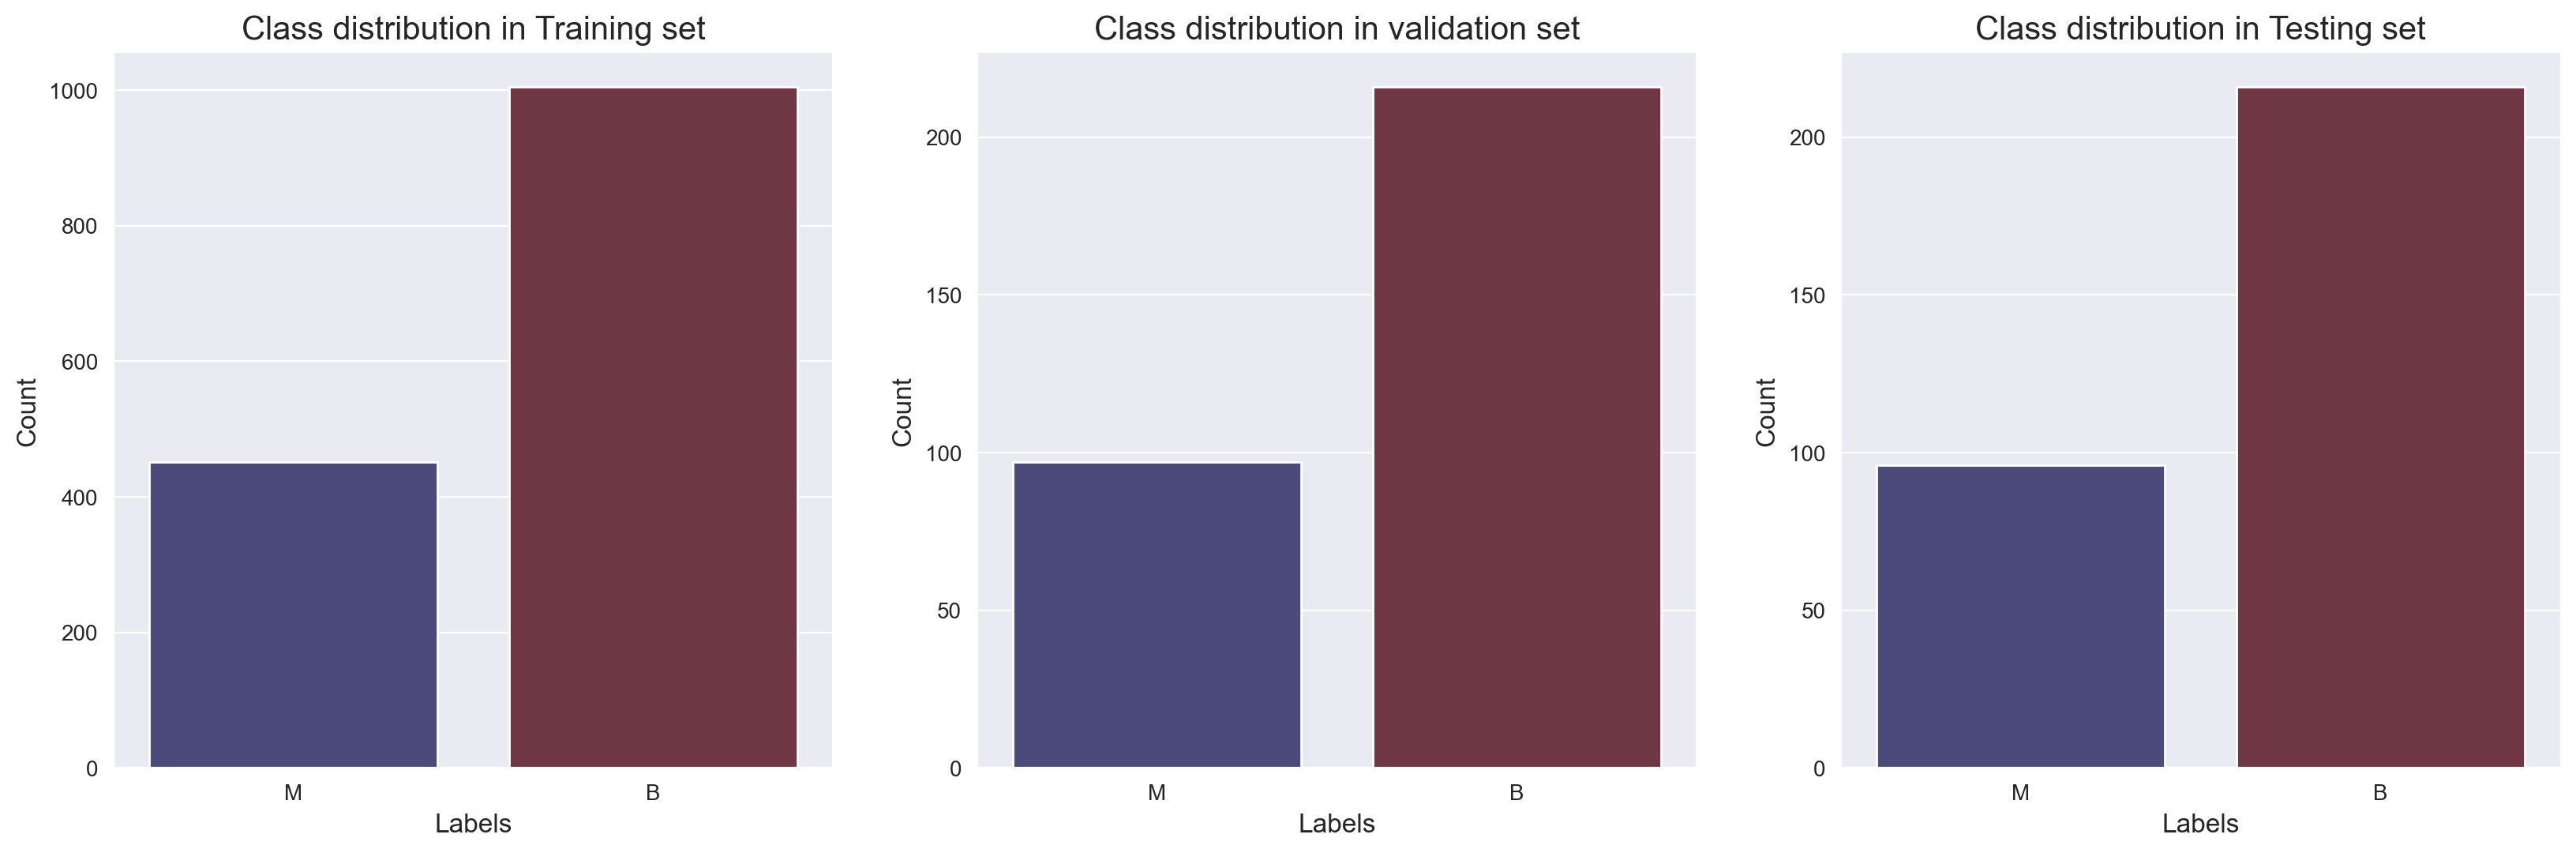

In [62]:
labels = ['M','B']

label1,count1 = np.unique(X_train.Label,return_counts=True)
label2,count2 = np.unique(X_val.Label,return_counts=True)
label3,count3 = np.unique(X_test.Label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire').set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire').set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire').set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

Implement at least three Deep Learning based classifiers: One needs to be a CNN, one can be a shallow neural network, e.g. a fully connected NN with one hidden layer.

In [63]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.metrics import Precision, Recall


CNN

In [64]:
# Load and preprocess data
IMG_SIZE = (32, 32)  # Adjust

def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0 # Normalize pixel values to [0, 1]
    return image

In [65]:
base_dir = "C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 24-25/Intro to Focus Areas/Data Science/data/BreaKHis_v1"

In [ ]:
# Convert DataFrame columns to lists
train_filepaths = X_train['FilePath'].tolist()
train_labels = X_train['Label'].tolist()

val_filepaths = X_val['FilePath'].tolist()
val_labels = X_val['Label'].tolist()

test_filepaths = X_test['FilePath'].tolist()
test_labels = X_test['Label'].tolist()

# load images and labels as TensorFlow Datasets
def create_dataset(filepaths, labels):    
    # Create TensorFlow datasets from paths and labels
    filepaths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    images_ds = filepaths_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    # Zip the datasets together
    return tf.data.Dataset.zip((images_ds, labels_ds))

In [67]:
i = 0
for filepath in train_filepaths:
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")

In [68]:
BATCH_SIZE = 32  # Set the batch size according to memory capacity

# Shuffle, batch, and prefetch the datasets
train_ds = create_dataset(train_filepaths, train_labels).shuffle(buffer_size=len(train_filepaths)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = create_dataset(val_filepaths, val_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = create_dataset(test_filepaths, test_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [69]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # Adjust input_shape to image dimensions, (3,3) is filter size, 3 is RGB color channels
    layers.MaxPooling2D((2, 2)), # reduces each dimension (height and width) by half, summarizing the main features
    layers.Conv2D(64, (3, 3), activation='relu'), # 64 filters
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), # number of neurons in the layer
    layers.Dense(1, activation='sigmoid')
])

c:\Users\igali\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [71]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6597 - loss: 0.6079 - precision_2: 0.6894 - recall_2: 0.8919 - val_accuracy: 0.8371 - val_loss: 0.4350 - val_precision_2: 0.8423 - val_recall_2: 0.9398
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7931 - loss: 0.4836 - precision_2: 0.8047 - recall_2: 0.9179 - val_accuracy: 0.8275 - val_loss: 0.4122 - val_precision_2: 0.8293 - val_recall_2: 0.9444
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7611 - loss: 0.5184 - precision_2: 0.7866 - recall_2: 0.8932 - val_accuracy: 0.8562 - val_loss: 0.4258 - val_precision_2: 0.9171 - val_recall_2: 0.8704
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7612 - loss: 0.5180 - precision_2: 0.7745 - recall_2: 0.9182 - val_accuracy: 0.7316 - val_loss: 0.4817 - val_precision_2: 0.7230 - val_recall_2: 0.9907
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8108 - loss: 0.4696 - precision_2: 0.8252 - recall_2: 0.9265 - val_

Evaluation

In [79]:
results = model.evaluate(test_ds)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results)):
    print(metrics[i] + ': ' + str(results[i]))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8125 - loss: 0.4413 - precision_2: 0.8774 - recall_2: 0.8615
Loss: 0.45870253443717957
Accuracy: 0.807692289352417
Precision: 0.8644859790802002
Recall(Sensitivity): 0.8564814925193787
